# Imports

In [702]:
import numpy as np
import pandas as pd
import random as rnd
from random import randint
import panel as pn
import panel.widgets as pnw
import matplotlib.pyplot as plt
from time import time
from numpy.linalg import norm
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.patches import Polygon as plt_Polygon
from matplotlib.collections import PatchCollection

import psycopg2
import math
from matplotlib.animation import FuncAnimation
import datetime
import csv
from postgis import Polygon,MultiPolygon
from postgis.psycopg import register

from time import time
import time
import progressbar

# 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import shapely.geometry as sg
import shapely.ops as so

%matplotlib inline
pn.extension()
# from Movie import *

# colors
# https://coolors.co/50514f-f25f5c-ffe066-247ba0-70c1b3

# Import taxis
# districts = {'xs': [], 'ys': []}


In [385]:
# import taxis file
taxi_matrix = pd.read_csv('offsets3.csv', header=None).transform(lambda y: y.transform(lambda x: (float(x.split(' ')[0]), float(x.split(' ')[1])))).to_numpy()

# Classes

## Movie

In [973]:
# from Frame import *
class Movie():
    def __init__(self, taxi_matrix=[], probability=10, districts=[], councils=[], parishes=[]):
#         self.index = 0
        self.num_total_taxis_inf = 0
        self.probability = probability/100
        
#       Territorial division
        self.countrys = {}
        self.districts = {}
        self.councils = {}
        self.parishes = {}
        self.xs_min, self.xs_max, self.ys_min, self.ys_max = -120000, 355000, -310000, 285000
        
        for d in districts:
            self.districts[d.name]=d
            
        for c in councils:
            self.councils[c.name]=c
            
        for p in parishes:
            self.parishes[p.name]=p
        
#       create taxis
        if len(taxi_matrix[0])>0:
            self.taxis = [Taxi(id=i, taxi_matrix=taxi_matrix) for i in progressbar.progressbar(range(len(taxi_matrix[0])), prefix='Create Taxis: ')]

#       create frames
        if len(taxi_matrix)>0:
            self.frames = [Frame(id_frame=i, taxis=self.taxis) for i in progressbar.progressbar(range(len(taxi_matrix)), prefix='Create Frames: ')]
        
#       set district info
        for places in progressbar.progressbar([self.districts, self.councils, self.parishes], prefix='Generate Polygons: '):
            for key in places:
                places[key].taxis = []
            
            
#       Assign Taxis
        conn = self.make_conn() 
        
        for t in progressbar.progressbar(self.taxis, prefix='Assign Taxis: '):
            point = t.get_first_position()
            if point!=(0, 0):
                self.get_taxi_district(conn, point, t)

#         for f in progressbar.progressbar(self.frames, prefix='Assign Taxis: '):
#             for t in f.get_all_taxis():
#                 dist_list = []
#                 for d in districts:
#                     if d.check_taxi_in_rect(t, f.id_frame):
#                         dist_list.append(d)
#                 if len(dist_list)==1:
#                     dist_list[0].add_taxi_in_frame(t, f)
#                 elif len(dist_list)>1:
#                     for dd in dist_list:
#                         if dd.check_taxi_in_district(t, f):
#                             dd.add_taxi_in_frame(t, f)

#         self.select_map_districts()
#         self.xs = districts['xs']
#         self.ys = districts['ys']

        self.xs, self.ys = [], []
        for p in self.districts:
            xs2, ys2 = self.districts[p].xy()
            self.xs+=xs2
            self.ys+=ys2

    def infect_first_taxis(self, num_inf=20, id_frame=1):
        dist_porto = self.districts['PORTO']
        dist_lisboa = self.districts['LISBOA']
            
        for t in dist_porto.taxis[0: int(num_inf/2)] + dist_lisboa.taxis[0: int(num_inf/2)]:
            t.frame_infec = 0
#         count_frame = 0
#         cout_infec_taxis = 0
        
# #       remove a infecção de todos os taxis
#         for taxi in self.taxis:
#             taxi.frame_infec = 10000
# #       percorre frame a frame e cria a primeira infecção
#         while cout_infec_taxis<num_inf:
#             cout_infec_taxis = self.frames[id_frame+count_frame].infect_first_taxis(num_inf)
#             count_frame+=1
            
        
    def infected_taxis(self, id_frame):
        return [taxi for taxi in self.taxis if taxi.frame_infec<id_frame]

    def propagate_infection(self, id_frame=1, dist_max = 50):
        infected_taxis = self.infected_taxis(id_frame)
        for frame in progressbar.progressbar(self.frames, prefix='Propagate Infection: '):
            infected_taxis = frame.propagate_infection(probability=self.probability, infected_taxis=[], dist_max=dist_max)
        self.num_total_taxis_inf = len(infected_taxis)
        
    def plot_test(self, i):
        scale=1/3000000
#         xs_min, xs_max, ys_min, ys_max = -120000, 355000, -310000, 285000
        width_in_inches = (self.xs_max-self.xs_min)/0.0254*1.1
        height_in_inches = (self.ys_max-self.ys_min)/0.0254*1.1
        
        fig = Figure(figsize=(width_in_inches*scale+5, height_in_inches*scale))
        self.frames[i].plot_test(fig)
#         self.plot_num_infect(fig, i)
        
        return fig

    def plot_frame(self, i):
        scale=1/3000000
#         xs_min, xs_max, ys_min, ys_max = -120000, 355000, -310000, 285000
        width_in_inches = (self.xs_max-self.xs_min)/0.0254*1.1
        height_in_inches = (self.ys_max-self.ys_min)/0.0254*1.1
        
        fig = Figure(figsize=(width_in_inches*scale+5, height_in_inches*scale))
        
#         ax = fig.add_axes()

#         self.plot_map(fig)

        self.frames[i].plot(fig, self.xs, self.ys)
        self.plot_num_infect(fig, i)
        self.plot_bar_chart(fig, i)
        
        return fig
    
    def plot_heatmap2(self, i):
        scale=1/3000000
        width_in_inches = (self.xs_max-self.xs_min)/0.0254*1.1
        height_in_inches = (self.ys_max-self.ys_min)/0.0254*1.1
        
        fig = Figure(figsize=(width_in_inches*scale+5, height_in_inches*scale))
        
        x, y, infec, num_infec = self.frames[i].get_all_taxis_info()
        num_infec = (np.array(num_infec)+3)#**2
        cmap = plt.cm.get_cmap('RdYlGn').reversed()
        scale=1/3000000
        xs_min, xs_max, ys_min, ys_max = -120000, 165000, -310000, 285000
        patches = []
        colors = []
        
        ax = fig.add_axes([0.1, 0.1, 0.35, 0.85])
        ax.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))
        
        for key in self.councils:
            self.councils[key].plot_heatmap(patches=patches)
            num_inf = len(self.councils[key].get_infec_taxis(i))
            for p in self.councils[key].polygons:
                colors.append(num_inf)

        p = PatchCollection(patches, alpha=0.4)
        p.set_array(np.array(colors))
        ax.add_collection(p)
        fig.colorbar(p, ax=ax)
        
        self.plot_num_infect(fig, i)
        self.plot_bar_chart(fig, i)
        
        return fig
    
    def plot_heatmap(self, i):
        scale=1/3000000
        width_in_inches = (self.xs_max-self.xs_min)/0.0254*1.1
        height_in_inches = (self.ys_max-self.ys_min)/0.0254*1.1
        
        fig = Figure(figsize=(width_in_inches*scale+5, height_in_inches*scale))
        colors = []
        
        for d in self.districts:
            for a in self.districts[d].polygons:
                colors.append(len(self.districts[d].get_infec_taxis(i)))
        
        self.frames[i].plot_heatmap(fig, self.xs, self.ys, colors)
        self.plot_num_infect(fig, i)
        self.plot_bar_chart(fig, i)
        
        return fig
    
#     def plot_heatmap(self, fig, i, hm_scale_x=100):
#         scale=1/3000000
#         width_in_inches = (self.xs_max-self.xs_min)/0.0254*1.1
#         height_in_inches = (self.ys_max-self.ys_min)/0.0254*1.1
        
#         fig = Figure(figsize=(width_in_inches*scale, height_in_inches*scale))
#         hm_scale_y = int(hm_scale_x*3.25)
        
#         harvest = np.zeros((hm_scale_y, hm_scale_x))
#         cmap = plt.cm.get_cmap('RdYlGn').reversed()
        
#         prop_x = hm_scale_x/(self.xs_max - self.xs_min)
#         prop_y = hm_scale_y/(self.ys_max - self.ys_min)
        
# #         set values
#         for taxi in self.taxis:
#             lat, long, inf, num_infect = taxi.get_info(i)
#             if (lat!=0 or long!=0):# and inf:
#                 x = int(prop_x*(lat - self.xs_min))
#                 y = (int(prop_y*(long - self.ys_min)) - hm_scale_y)*-1
#                 harvest[y][x] +=1
# #         xs_min, xs_max, ys_min, ys_max = -120000, 355000, -310000, 285000


            
        
#         ax = fig.add_axes([0.1, 0.1, 0.85, 0.85],
#                   xticklabels=[])
        
# #         ax = fig.add_axes([0.1, 0.1, 0.35, 0.85],
# #                    xticklabels=[])
        
#         im = ax.imshow(harvest, cmap=cmap)

#         # Create colorbar
#         cbarlabel="Quality Rating"

#         cbar = ax.figure.colorbar(im, ax=ax)
#         cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

#         ax.set_title("Harvest of local farmers (in tons/year)")
#         return fig

    def plot_quadtree(self, i):
        scale=1/3000000
        width_in_inches = (self.xs_max-self.xs_min)/0.0254*1.1
        height_in_inches = (self.ys_max-self.ys_min)/0.0254*1.1
        
        fig = Figure(figsize=(width_in_inches*scale+5, height_in_inches*scale))
        
        self.frames[i].plot_quadtree(fig)
        self.plot_num_infect(fig, i)
        self.plot_bar_chart(fig, i)
        return fig
    
    def plot_num_infect(self, fig, i):
        ax = fig.add_axes([0.53, 0.1, 0.3, 0.3],
                   xticklabels=[])
        
        ax.set(xlim=(0, len(self.frames)), ylim=(0, self.num_total_taxis_inf))
        num_infected_taxis_list = []
        
        for j in range(i):
            num_infected_taxis_list.append(self.frames[j].num_infected_taxis)
            
        fs = [n for n in range(i)]
        ax.plot(fs,np.array(num_infected_taxis_list), color='#8BCAE5')
        
        return fig
    
    def plot_bar_chart(self, fig, i):
        ax = fig.add_axes([0.53, 0.65, 0.3, 0.3],
                   xticklabels=[])
        ax.set_title('Amount Frequency')
        
        infect_heights = np.array([len(self.districts[d].get_infec_taxis(i)) for d in self.districts])
        no_infec_heights = np.array([len(self.districts[d].taxis) for d in self.districts]) - infect_heights
        
        bars = [d for d in self.districts]
        y_pos = range(len(bars))
        
        ax.bar(y_pos, no_infec_heights, color="#72E19A")
        ax.bar(y_pos, infect_heights, bottom=no_infec_heights, color="#FC9797")
    
        ax.set_xticks(np.arange(18))
        ax.set_xticklabels(bars, rotation=90)
        
        # Make some labels.
        labels = infect_heights
        rects = ax.patches

        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height , label,
                    ha='center', va='bottom')
            
        colors = {'Infec':'#FC9797', 'No Infec':'#72E19A'}         
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        ax.legend(handles, labels)
        
        return fig
        
    def make_conn(self):
        conn = None
        conn = psycopg2.connect(database="lucparada", user="lucparada", password='', host="127.0.0.1", port="9876")

        ts_i = 1570665600
        ts_f = 1570667000

        register(conn)
        return conn
    
    def get_taxi_district(self, conn, point, taxi):
        cursor_psql = conn.cursor()
        sql="SELECT distrito, concelho, freguesia FROM cont_aad_caop2018 WHERE ST_Contains(proj_boundary, ST_GeometryFromText('POINT(" + str(point[0]) + " " + str(point[1]) + ")',3763))"
        cursor_psql.execute(sql)
        results = cursor_psql.fetchall()
        
        district = ''
        council = ''
        parish = ''
        
        for row in results:
            district, council, parish = row[0], row[1], row[2]
            
        if district in self.districts:
            self.districts[district].taxis.append(taxi)
        
        if council in self.councils:
            self.councils[council].taxis.append(taxi)
            
        if parish in self.parishes:
            self.parishes[parish].taxis.append(taxi)
            
#         for d in self.districts:
#             if d == district:
#                 self.districts[d].taxis.append(taxi)
                
#         for c in self.councils:
#             if c == council:
#                 self.councils[c].taxis.append(taxi)
        
#         for p in self.parishes:
#             if p == parish:
#                 self.parishes[p].taxis.append(taxi)

    def select_map_districts(self):
#         xs_min, xs_max, ys_min, ys_max = -120000, 165000, -310000, 285000
#         width_in_inches = (xs_max-xs_min)/0.0254*1.1
#         height_in_inches = (ys_max-ys_min)/0.0254*1.1
#         ax = fig.add_subplot()
#         fig, ax = plt.subplots(figsize=(width_in_inches*scale, height_in_inches*scale))
#         ax.axis('off')
#         ax.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))
        cursor_psql = conn.cursor()
        sql = "select distrito,st_union(st_simplify(proj_boundary,100,FALSE)) from cont_aad_caop2018 group by distrito;"
        cursor_psql.execute(sql)
        results = cursor_psql.fetchall()
        xs , ys = [],[]
        
        for row in progressbar.progressbar(results, prefix='Select Districts: '):
            geom = row[1]
            if type(geom) is MultiPolygon:
                for pol in geom:
                    xys = pol[0].coords
                    xs2, ys2 = [],[]
                    for (x,y) in xys:
                        xs2.append(x)
                        ys2.append(y)
                    xs.append(xs2)
                    ys.append(ys2)
#                     ax.plot(xs,ys,color='black',lw='0.2')
            else:
                xys = geom[0].coords
                xs2, ys2 = [],[]
                for (x,y) in xys:
                    xs2.append(x)
                    ys2.append(y)
#                 ax.plot(xs,ys,color='black',lw='0.2')
                xs.append(xs2)
                ys.append(ys2)

        self.xs = xs
        self.ys = ys
        
    def plot_map(self, fig):
        ax = fig.add_axes()
        
        for i in range(len(xs)):
            ax.plot(xs[i], ys[i],color='black',lw='0.2')

    def __str__(self):
        return 'Nº frames: ' + str(len(self.frames)) | 'Infected taxis: ' + len([0 for t in self.taxis if t.frame_infec<10000])


## Frame

In [703]:
# from Taxi import *
# import random
# import matplotlib.pyplot as plt
# import numpy as np
# from numpy.linalg import norm
# import pandas as pd

class Frame():
    def __init__(self, id_frame=0, taxis=[]):
        self.id_frame = id_frame
#         xs_min, xs_max, ys_min, ys_max = -120000, 355000, -310000, 285000
        left_top = (-120000, 285000)
        right_bottom = (355000, -310000)

        # left_top = (-10000, 10000)
        # right_bottom = (10000, -10000)
        
        self.taxis = taxis
        self.root = Node(left_top,right_bottom, 0, id_frame=self.id_frame)
        self.num_infected_taxis = 0

        for taxi in taxis:
            x, y, inf, num_indect = taxi.get_info(self.id_frame)
            if x!=0 or y!=0:
                self.root.add_taxi(taxi)

    def infect_first_taxis(self, num_inf=10):
        for taxi in self.taxis:
            lat, long, inf, num_infect = taxi.get_info(self.id_frame)
            if (lat != 0 or long != 0) and num_inf > 0:
#                 print(self.id_frame)
                taxi.frame_infec = self.id_frame
                num_inf -= 1
        return len([0 for taxi in self.taxis if taxi.frame_infec<10000])

    def propagate_infection(self, probability=0.1, infected_taxis = [], dist_max = 50):
        if infected_taxis == []:
#             infected_taxis = self.get_all_infected_taxis()
            infected_taxis = [taxi for taxi in self.taxis if taxi.frame_infec<10000]
            
        new_infected_taxis = []
                    
        for taxi in infected_taxis:
            lat, long, inf, num_infect = taxi.get_info(self.id_frame)
            if lat!= 0 or long!= 0:                 
                for t in self.root.scan(lat, long, self.id_frame, dist_max=dist_max):
                    if t.frame_infec > self.id_frame and probability >= rnd.uniform(0,1):
                        t.frame_infec = self.id_frame
                        taxi.num_infec+=1
                        new_infected_taxis.append(t)
                        
        infected_taxis += new_infected_taxis
        self.num_infected_taxis = len(infected_taxis)
        return infected_taxis

    def get_all_taxis(self):
        return self.root.get_all_taxis()

    def __str__(self):
        return str(self.root)

    def plot_test(self, fig = Figure()):
        self.root.plot_test(fig)
        return fig
#         plt.show()

    def plot_quadtree(self, fig = Figure()):
        x, y, infec, num_infec = self.get_all_taxis_info()
        num_infec = (np.array(num_infec)+3)#**2

        # Plot
        scale=1/3000000
        xs_min, xs_max, ys_min, ys_max = -120000, 165000, -310000, 285000
        ax = fig.add_axes([0.1, 0.1, 0.35, 0.85])
        
        self.root.plot_quadtree(ax)
        return fig

    def plot(self, fig, xs, ys):
        x, y, infec, num_infec = self.get_all_taxis_info()
        num_infec = (np.array(num_infec)+3)#**2

        # Plot
        scale=1/3000000
        xs_min, xs_max, ys_min, ys_max = -120000, 165000, -310000, 285000
#         width_in_inches = (xs_max-xs_min)/0.0254*1.1
#         height_in_inches = (ys_max-ys_min)/0.0254*1.1
        
        ax = fig.add_axes([0.1, 0.1, 0.35, 0.85])

        ax.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))
        ax.scatter(x, y, num_infec, color=['#f25f5c' if c else '#70c1b3' for c in infec], alpha=.8)
        
        for i in range(len(xs)):
            ax.plot(xs[i], ys[i],color='black',lw='0.2')
        
        return fig

    def plot_heatmap(self, fig, xs, ys, colors):
        x, y, infec, num_infec = self.get_all_taxis_info()
        num_infec = (np.array(num_infec)+3)#**2
        cmap = plt.cm.get_cmap('RdYlGn').reversed()
        scale=1/3000000
        xs_min, xs_max, ys_min, ys_max = -120000, 165000, -310000, 285000
        patches = []
        
        for i in range(len(xs)):
            polygon = plt_Polygon( np.array([[x2, y2] for x2, y2 in zip(xs[i], ys[i])]), True)
            patches.append(polygon)   

        ax = fig.add_axes([0.1, 0.1, 0.35, 0.85])
        ax.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))
        p = PatchCollection(patches, alpha=0.4)
#         p = PatchCollection(patches, alpha=0.4, cmap=cmap)
        p.set_array(np.array(colors))
        ax.add_collection(p)
        fig.colorbar(p, ax=ax)
        
        
        
#         x, y, infec, num_infec = self.get_all_taxis_info()
#         num_infec = (np.array(num_infec)+3)#**2

#         # Plot
#         scale=1/3000000
#         xs_min, xs_max, ys_min, ys_max = -120000, 165000, -310000, 285000
# #         width_in_inches = (xs_max-xs_min)/0.0254*1.1
# #         height_in_inches = (ys_max-ys_min)/0.0254*1.1
        
#         ax = fig.add_axes([0.1, 0.1, 0.35, 0.85])

#         ax.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))
#         ax.scatter(x, y, num_infec, color=['#f25f5c' if c else '#70c1b3' for c in infec], alpha=.8)
        
#         for i in range(len(xs)):
#             ax.plot(xs[i], ys[i],color='black',lw='0.2')
#         plt.plot()
        return fig

    def scan(self, x, y, dist_max = 50):
        return self.root.scan(x, y, dist_max=dist_max)

    def __len__(self):
        return len(self.root)

    def get_all_taxis_info(self):
        return self.root.get_all_taxis_info()

    def get_all_infected_taxis(self):
        return self.root.get_all_infected_taxis(self.id_frame)


## Node

In [686]:
class Node():
    def __init__(self, left_top=(0,0), right_bottom=(0,0), depth=0, id_frame=0):
        self.children = []
        self.left_top = left_top
        self.right_bottom = right_bottom
        self.id_frame = id_frame
        self.taxis = []
        self.limit = 50
        self.depth = depth

    def add_taxi(self, taxi):
        self.taxis.append(taxi)

        if len(self.taxis)>self.limit and ((abs(self.right_bottom[0]-self.left_top[0])>50) or (abs(self.left_top[1]-self.right_bottom[1])>50)) :
            x1, x2, y1, y2 = self.get_vertices()
            x_half = x1+(x2 - x1)/2
            y_half = y1-(y1 - y2)/2

            self.children.append(Node((x1, y1), (x_half, y_half), self.depth+1, self.id_frame))  #left top
            self.children.append(Node((x_half, y1), (x2, y_half), self.depth+1, self.id_frame)) # right top
            self.children.append(Node((x1, y_half), (x_half, y2), self.depth+1, self.id_frame)) # bottom left
            self.children.append(Node((x_half, y_half), (x2, y2), self.depth+1, self.id_frame)) # bottom rigth
        self.deal_taxis()

    def deal_taxis(self):
        if len(self.children)!=0:
            x1, x2, y1, y2 = self.get_vertices()
            x_half = x1+abs(x2 - x1)/2
            y_half = y1-abs(y1 - y2)/2

            for t in self.taxis:
                x, y, inf, num_infect = t.get_info(self.id_frame)
                
                if x<x_half and y>y_half:
                    self.children[0].add_taxi(t)
                elif x>=x_half and y>y_half:
                    self.children[1].add_taxi(t)
                elif x<x_half and y<=y_half:
                    self.children[2].add_taxi(t)
                else:
                    self.children[3].add_taxi(t)
            self.taxis = []

    def get_all_taxis(self):
        taxis = self.taxis
        for c in self.children:
            taxis += c.get_all_taxis()

        return taxis

    def get_all_infected_taxis(self,id_frame):
        taxi = []
        for t in self.taxis:
            xx, yy, inf, num_infect = t.get_info(id_frame)
            if inf:
                taxi.append(t)
        for c in self.children:
            taxi += c.get_all_infected_taxis(id_frame)
        return taxi

    def get_all_taxis_info(self):
        x, y, infec, num_infec = [], [], [], []
        for t in self.taxis:
            xx, yy, zz, ww = t.get_info(self.id_frame)
            x.append(xx)
            y.append(yy)
            infec.append(zz)
            num_infec.append(ww)
        for c in self.children:
            xx, yy, zz, n_infec = c.get_all_taxis_info()
            x+=xx
            y+=yy
            infec+=zz
            num_infec+=n_infec
        return x, y, infec, num_infec

    def get_vertices(self):
        x1 = self.left_top[0]
        x2 = self.right_bottom[0]
        y1 = self.left_top[1]
        y2 = self.right_bottom[1]

        return x1, x2, y1, y2

    def __str__(self):
        s = ''
        for c in self.children:
            s += "\n    " + str(c)
        return str(self.left_top) + str(self.right_bottom) + str(len(self.taxis)) + s

    def __add__(self):
        pass

    def __len__(self):
        l = 0
        for c in self.children:
            l+=len(c)
        return 1 + l

    def get_list_coords(self):
        x1, x2, y1, y2 = self.get_vertices()
        xs, ys = np.array([x1, x2, x2, x1, x1]), np.array([y1, y1, y2, y2, y1])
        for c in self.children:
            xcs, ycs =  c.get_list_coords()
#             if xcs[0]!= xs[len(xs)-1] and ycs[0]!= ys[len(ys)-1]:
#                 xs = numpy.append(xs, xs[len(xs)-1])
#                 ys = numpy.append(ys, ycs[0])
            xs = np.concatenate((xs, xcs), axis=0)
            ys = np.concatenate((ys, ycs), axis=0)
        return xs, ys


    def plot(self, ax = None):
        for c in self.children:
            c.plot(ax=ax)

        x1, x2, y1, y2 = self.get_vertices()
        ax.plot(np.array([x1, x2, x2, x1, x1]),np.array([y1, y1, y2, y2, y1]),c='k',ls='-',label='Rand', alpha=0.3)


    def plot_test(self, fig = Figure()):
        for t in self.taxis:
            t.plot(frame_index=self.id_frame)
        for c in self.children:
            c.plot_test(fig)

        x1, x2, y1, y2 = self.get_vertices()
        plt.plot(np.array([x1, x2, x2, x1, x1]),np.array([y1, y1, y2, y2, y1]),c='k',ls='-',label='Rand', alpha=0.3)
        
    def plot_quadtree(self, ax=None):        
        
        for t in self.taxis:
            t.plot2(ax, frame_index=self.id_frame)
        for c in self.children:
            c.plot_quadtree(ax)

        x1, x2, y1, y2 = self.get_vertices()
        ax.plot(np.array([x1, x2, x2, x1, x1]),np.array([y1, y1, y2, y2, y1]),c='k',ls='-',label='Rand', alpha=0.3)

    def check_frontiers(self, x, y, dist_max):
        x1, x2, y1, y2 = self.get_vertices()
        x_half = x1+abs(x2 - x1)/2
        y_half = y1-abs(y1 - y2)/2

        dist = np.sqrt((x-x_half)**2+(y-y_half)**2)
        dist2 = np.sqrt((x1-x_half)**2+(y1-y_half)**2)
#         dist2 = np.linalg.norm( np.array([x_half, y_half]) - np.array([x1, y1]))

#         print(dist)
#         print(dist_max + dist2)
#         print(dist <= dist_max + dist2)
#         print('-------------------------')

        return dist <= dist_max + dist2
#         return True

    def scan(self, x, y, id_frame, dist_max = 50):
        
        taxis = []        

        if self.check_frontiers(x, y, dist_max):
#             print('aqui')
            for c in self.children:
                taxis += c.scan(x, y, id_frame, dist_max=dist_max)
            for t in self.taxis:
                lat, long, inf, num_infect = t.get_info(id_frame)
                if not inf and np.sqrt( (lat-x)**2 + (long-y)**2 )<dist_max:
                    taxis.append(t)
#             if len(self.taxis)!=0:
#                 print(len(self.taxis))     
        return taxis


## Taxi

In [687]:
import matplotlib.pyplot as plt

class Taxi():
    def __init__(self, id=0, frame_infec=10000, taxi_matrix=[]):
        self.id = id
#         self.coord = []
        self.frame_infec = frame_infec
        self.taxi_matrix = taxi_matrix
        self.num_infec = 0

    def __str__(self):
        return 'id: ' + str(self.id)

#     def add_coord(self, lat, lng):
#         self.coord.append((lat, lng))

    def get_info(self, id_frame):
        x = self.taxi_matrix[id_frame][self.id][0]
        y = self.taxi_matrix[id_frame][self.id][1]
        inf = id_frame>=self.frame_infec
        return x, y, inf, self.num_infec
    
    def plot_fig(self, fig=None, ax=None, frame_index=0):
        if(fig!=None):
            ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])
        ax.scatter([self.x], [self.y])
    

    def plot(self, color='green', markersize=1, alpha=.5, frame_index=0):
        lat, lng, inf, num_infec = self.get_info(frame_index)
        if inf:
            color = 'red'
        plt.plot([lat], [lng], 'ro', color=color, markersize=markersize, alpha=alpha)
        
    def plot2(self, ax, color='green', markersize=1, alpha=.5, frame_index=0):
        lat, lng, inf, num_infec = self.get_info(frame_index)
        if inf:
            color = 'red'
        ax.plot([lat], [lng], 'ro', color=color, markersize=markersize, alpha=alpha)
        
    def get_first_position(self):
        for point in self.taxi_matrix:
            x = point[self.id][0]
            y = point[self.id][1]
            if x!=0 or y!=0:
                return point[self.id]
        return (0, 0)



## District

In [949]:
class District():
    def __init__(self, name, freguesia):
        self.name = name
        self.polygons = []
        self.rects = []
        self.freguesia = freguesia
        self.taxis = []
        self.dimension = [-310000, 285000, -120000, 355000]
        
#         [-54835.561400000006, -355000, 310000, 200494.2405999992]

    def add_polygon(self, xs, ys):
        self.polygons.append(Polygon([(xs[i], ys[i]) for i in range(len(xs))]))
        for p in self.polygons:
            xs, ys = p.exterior.xy
            
            x_left = min(xs)
            x_right = max(xs)
            
            y_top = min(ys)
            y_bottom = max(ys)
            
            if self.dimension[0] > x_left:
                self.dimension[0] = x_left
                
            if self.dimension[1] < y_top:
                self.dimension[1] = y_top
                
            if self.dimension[2] < x_right:
                self.dimension[2] = x_right
                
            if self.dimension[3] > y_bottom:
                self.dimension[3] = y_bottom
            
            self.rects.append( ((x_left, y_top), (x_right, y_bottom)) )
            
#     def check_taxi_in_rect(self, taxi, id_frame):
#         x, y, val1, val2 = taxi.get_info(id_frame)
#         for r in self.rects:
#             if r[0][0] <= x <= r[1][0] and r[0][1] <= y <= r[1][1]:
#                 return True
#         return False
        
#     def set_taxis_by_frames(self, frames):
#         pass
#         for frame in frames:
#             self.taxis.append([t for t in frame.get_all_taxis() if self.check_taxi_in_district(t, frame.id_frame)])
            
    def check_taxi_in_district(self, taxi, frame):
        id_frame = frame.id_frame
#         print(id_frame)
        x, y, inf, w = taxi.get_info(id_frame)
        point = Point(x, y)
        for p in self.polygons:
            if p.contains(point):
                return True
        return False
        
    def plot(self, fig=Figure(), id_frame=0):
        scale=1/3000000
        xs_min, xs_max, ys_min, ys_max = self.dimension
        width_in_inches = (xs_max-xs_min)/0.0254*1.1
        height_in_inches = (ys_max-ys_min)/0.0254*1.1
        
        fig = Figure(figsize=(width_in_inches*scale, height_in_inches*scale))
         
        ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])
        for p in self.polygons:
            xs, ys = p.exterior.xy    
#             print(xs)
            ax.plot(xs, ys,color='black',lw='0.2')
        x, y = [], []
        for t in self.taxis:
            xx, yy, val1, val2 = t.get_info(id_frame)
            if (xx, yy) != (0,0):
                x.append(xx)
                y.append(yy)
#             t.plot_fig(id_frame=id_frame, ax=ax)

        ax.scatter(x, y, [1]*len(x), alpha=.8)
        return fig
    
    def plot_heatmap(self, patches=[]):
        for p in self.polygons:
            xs, ys = p.exterior.xy    
            ax.plot(xs, ys,color='black',lw='0.2')
            polygon = plt_Polygon( np.array([[x2, y2] for x2, y2 in zip(xs, ys)]), True)
            patches.append(polygon)
    
    def xy(self):
        xs, ys = [], []
        for p in self.polygons:
            xs2, ys2 = p.exterior.xy
            xs.append(xs2)
            ys.append(ys2)
            
        return xs, ys
    
    def get_infec_taxis(self, i):
        return [t for t in self.taxis if t.frame_infec<=i]
        
        
    def __str__(self):
        return 'Name: ' + self.name 

# Functions

## Create taxis/districts

In [943]:
def create_taxis():
#     taxi_matrix = pd.read_csv('offsets3.csv', header=None).transform(lambda y: y.transform(lambda x: (float(x.split(' ')[0]), float(x.split(' ')[1])))).to_numpy()
    taxi_matrix = pd.read_csv('offsets3.csv', header=None).applymap(lambda e: (float(e.split(' ')[0]), float(e.split(' ')[1]))).to_numpy()
    return [Taxi(id=i, taxi_matrix=taxi_matrix) for i in progressbar.progressbar(range(len(taxi_matrix[0])))]

def create_parishes():
    conn = psycopg2.connect(database="lucparada", user="lucparada", password='', host="127.0.0.1", port="9876")
    register(conn)

    cursor_psql = conn.cursor()
    
    sql = "select freguesia,st_union(st_simplify(proj_boundary,100,FALSE)) from cont_aad_caop2018 group by freguesia;"
    cursor_psql.execute(sql)
    results = cursor_psql.fetchall()
    xs , ys = [],[]
    
    parishes = []

    for row in progressbar.progressbar(results, prefix='Create Parishes: '):
        parish = District(row[0], [])
        geom = row[1]
        if type(geom) is MultiPolygon:
            for pol in geom:
                xys = pol[0].coords
                xs2, ys2 = [],[]
                for (x,y) in xys:
                    xs2.append(x)
                    ys2.append(y)
                parish.add_polygon(xs2, ys2)
        else:
            xys = geom[0].coords
            xs2, ys2 = [],[]
            for (x,y) in xys:
                xs2.append(x)
                ys2.append(y)
            parish.add_polygon(xs2, ys2)
        parishes.append(parish)
    return parishes

def create_council():
    conn = psycopg2.connect(database="lucparada", user="lucparada", password='', host="127.0.0.1", port="9876")
    register(conn)

    cursor_psql = conn.cursor()
    
    council_freguesia = {}
    sql = "select concelho, freguesia from cont_aad_caop2018;"
    cursor_psql.execute(sql)
    results = cursor_psql.fetchall()
    for row in results:
        if row[0] not in council_freguesia:
            council_freguesia[row[0]] = [row[1]]
        else:
            council_freguesia[row[0]].append(row[1])
    
    sql = "select concelho,st_union(st_simplify(proj_boundary,100,FALSE)) from cont_aad_caop2018 group by concelho;"
    cursor_psql.execute(sql)
    results = cursor_psql.fetchall()
    xs , ys = [],[]
    
    councils = []

    for row in progressbar.progressbar(results, prefix='Create Council: '):
        council = District(row[0], council_freguesia[row[0]])
        geom = row[1]
        if type(geom) is MultiPolygon:
            for pol in geom:
                xys = pol[0].coords
                xs2, ys2 = [],[]
                for (x,y) in xys:
                    xs2.append(x)
                    ys2.append(y)
                council.add_polygon(xs2, ys2)

        else:
            xys = geom[0].coords
            xs2, ys2 = [],[]
            for (x,y) in xys:
                xs2.append(x)
                ys2.append(y)
            council.add_polygon(xs2, ys2)
        councils.append(council)
    return councils

def create_district():
    conn = psycopg2.connect(database="lucparada", user="lucparada", password='', host="127.0.0.1", port="9876")
    register(conn)

    cursor_psql = conn.cursor()
    
    district_freguesia = {}
    sql = "select distrito, freguesia from cont_aad_caop2018;"
    cursor_psql.execute(sql)
    results = cursor_psql.fetchall()
    for row in results:
        if row[0] not in district_freguesia:
            district_freguesia[row[0]] = [row[1]]
        else:
            district_freguesia[row[0]].append(row[1])
    
    sql = "select distrito,st_union(st_simplify(proj_boundary,100,FALSE)) from cont_aad_caop2018 group by distrito;"
    cursor_psql.execute(sql)
    results = cursor_psql.fetchall()
    xs , ys = [],[]
    
    districts = []

    for row in progressbar.progressbar(results, prefix='Create Districts: '):
        district = District(row[0], district_freguesia[row[0]])
        geom = row[1]
        if type(geom) is MultiPolygon:
            for pol in geom:
                xys = pol[0].coords
                xs2, ys2 = [],[]
                for (x,y) in xys:
                    xs2.append(x)
                    ys2.append(y)
                district.add_polygon(xs2, ys2)

        else:
            xys = geom[0].coords
            xs2, ys2 = [],[]
            for (x,y) in xys:
                xs2.append(x)
                ys2.append(y)
            district.add_polygon(xs2, ys2)
        districts.append(district)
    return districts

# variables
# movie = None
# taxis = create_taxis()
districts = create_district()
councils = create_council()
parishes = create_parishes()




Create Districts: 100% (18 of 18) |######| Elapsed Time: 0:00:00 Time:  0:00:00
Create Council: 100% (278 of 278) |######| Elapsed Time: 0:00:00 Time:  0:00:00
Create Parishes: 100% (2706 of 2706) |###| Elapsed Time: 0:00:01 Time:  0:00:01


## Create Movie

### Code

In [963]:
# Panel of controlls
def updateMovie():
    movie = Movie(taxi_matrix = taxi_matrix[0:int(len(taxi_matrix)*(range_video.value/100)):density.value], probability=probability.value, districts=districts, councils=councils, parishes=parishes)
    movie.infect_first_taxis(num_inf=num_inf.value)
    movie.propagate_infection(dist_max=dist_max.value)
    return movie

title = '<br>\n# Movie Features\n###'
density = pn.widgets.IntSlider(name='Density', start=1, end=10, step=1, value=10)
range_video = pn.widgets.IntSlider(name='Range', start=1, end=100, step=1, value=20)
num_inf  = pn.widgets.IntSlider(name='Number of Infected Taxis', start=1, end=100, step=1, value=20)
dist_max  = pn.widgets.IntSlider(name='Distance', start=0, end=1000, step=5, value=50)
probability = pn.widgets.IntSlider(name='Probability of infection', start=0, end=100, step=1, value=10)

@pn.depends(density, num_inf)
def previewMap(de, n):
    np.random.seed(19680801)
    data = np.random.randn(2, 100)
#   
    colors = [0.0 for i in range(100)]
    count = 0
    while count<100:
        colors[count] = 1.0
        count+=int((len(taxi_matrix[0: len(taxi_matrix): de])/len(taxi_matrix))*100)+1
#         if i% ) == 0 else 1.0

    frame_dencity = np.array([colors])

    fig = Figure(figsize=(12, 5))
    ax1 = fig.add_axes([0.1, 0.2, 0.5, 0.7])
    ax1.scatter(data[0], data[1], color=['green' for i in range(len(data[0]))])
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    ax2 = fig.add_axes([0.1, 0.1, 0.5, 0.15],
                   xticklabels=[])
    
    ax2.imshow(frame_dencity)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    return fig

# Panel dashboard
def updaetMovieBtnClick(event):
    movie = updateMovie(interval=interval.value, num_inf=num_inf.value)
    
def mpl_plot(frame_num, select_type_value):
    figsize_x=8
    figsize_y=9
#     return movie.plot_test(frame_num)
    
    
    if select_type_value == 'Point':
        return movie.plot_frame(frame_num)
    elif select_type_value == 'HeatMap':
        return movie.plot_heatmap2(frame_num)
    elif select_type_value == 'QuadTree':
        return movie.plot_quadtree(frame_num)

def show_frame(frame_num=0, select_type_value='Point'):
    return mpl_plot(frame_num, select_type_value)

title = '<br>\n# Room Occupancy\n'
play_video = '<br>\n### Play Video'


# button_play = pn.widgets.Button(name='▶', width=50)
# button_pause = pn.widgets.Button(name='||', width=50)

# def function_play(event):
#     pass
# button.button_play(function_play)





### Functions

Row
    [0] Column
        [0] Markdown(str)
        [1] IntSlider(end=10, name='Density', start=1, value=10)
        [2] IntSlider(end=100, name='Range', start=1, value=20)
        [3] IntSlider(end=100, name='Number of Infected T..., start=1, value=20)
        [4] IntSlider(end=100, name='Probability o..., value=10)
        [5] IntSlider(end=1000, name='Distance', step=5, value=50)
    [1] Column
        [0] ParamFunction(function)
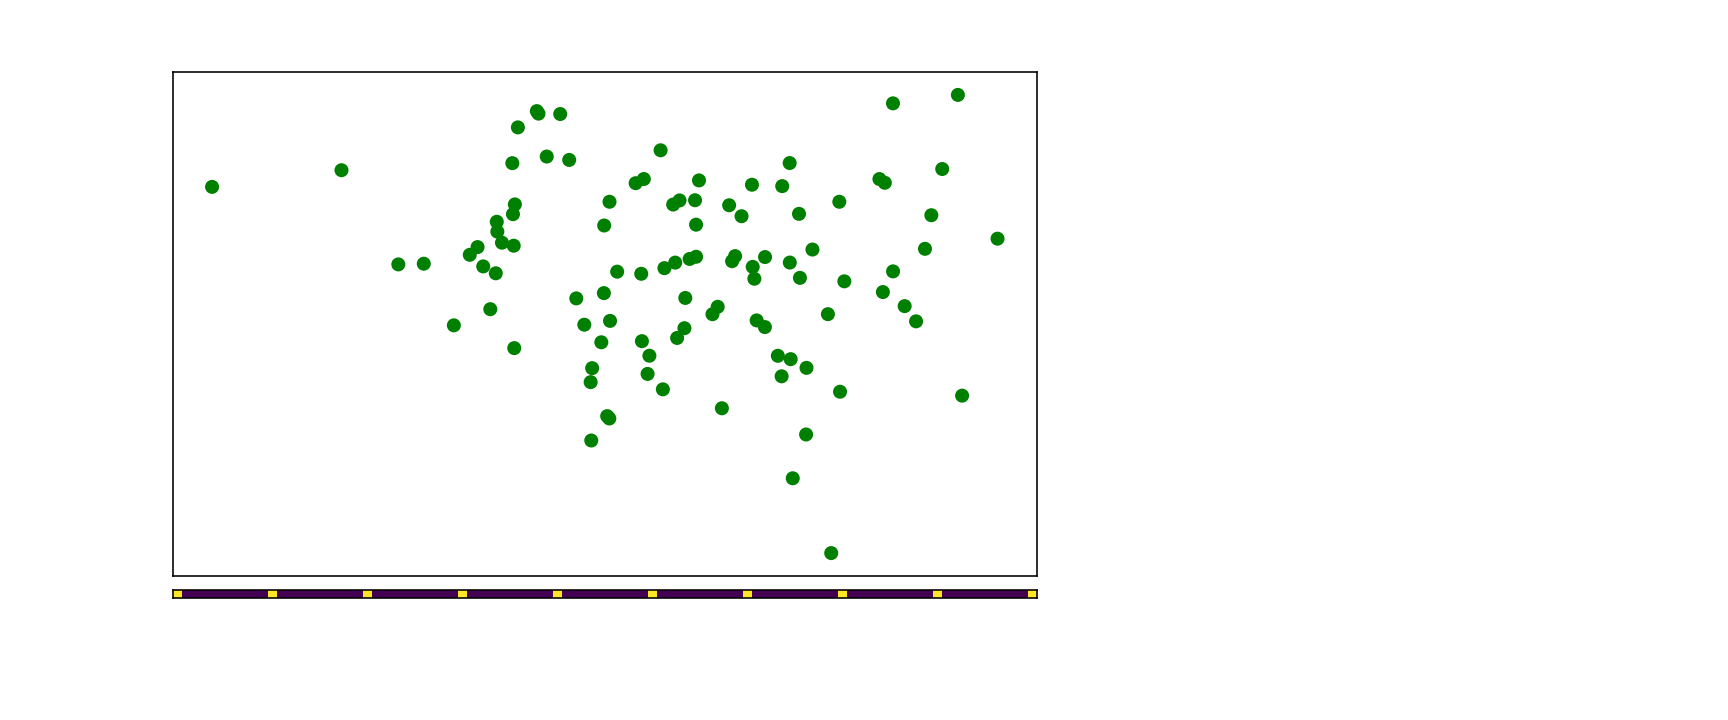

In [959]:
pn.Row(pn.Column(title, density, range_video, num_inf, probability, dist_max), pn.Column(previewMap))

## Plot

Create Taxis: 100% (1660 of 1660) |######| Elapsed Time: 0:00:00 Time:  0:00:00
Create Frames: 100% (173 of 173) |#######| Elapsed Time: 0:00:04 Time:  0:00:04
Generate Polygons: 100% (3 of 3) |#######| Elapsed Time: 0:00:00 Time:  0:00:00
Assign Taxis: 100% (1660 of 1660) |######| Elapsed Time: 0:00:02 Time:  0:00:02
Propagate Infection: 100% (173 of 173) |#| Elapsed Time: 0:00:03 Time:  0:00:03


Column
    [0] Markdown(str)
    [1] RadioButtonGroup(name='Type', options=['Point', 'HeatMap', ...], value='Point')
    [2] ParamFunction(function)
    [3] Player(end=173, interval=1000, loop_policy='loop')
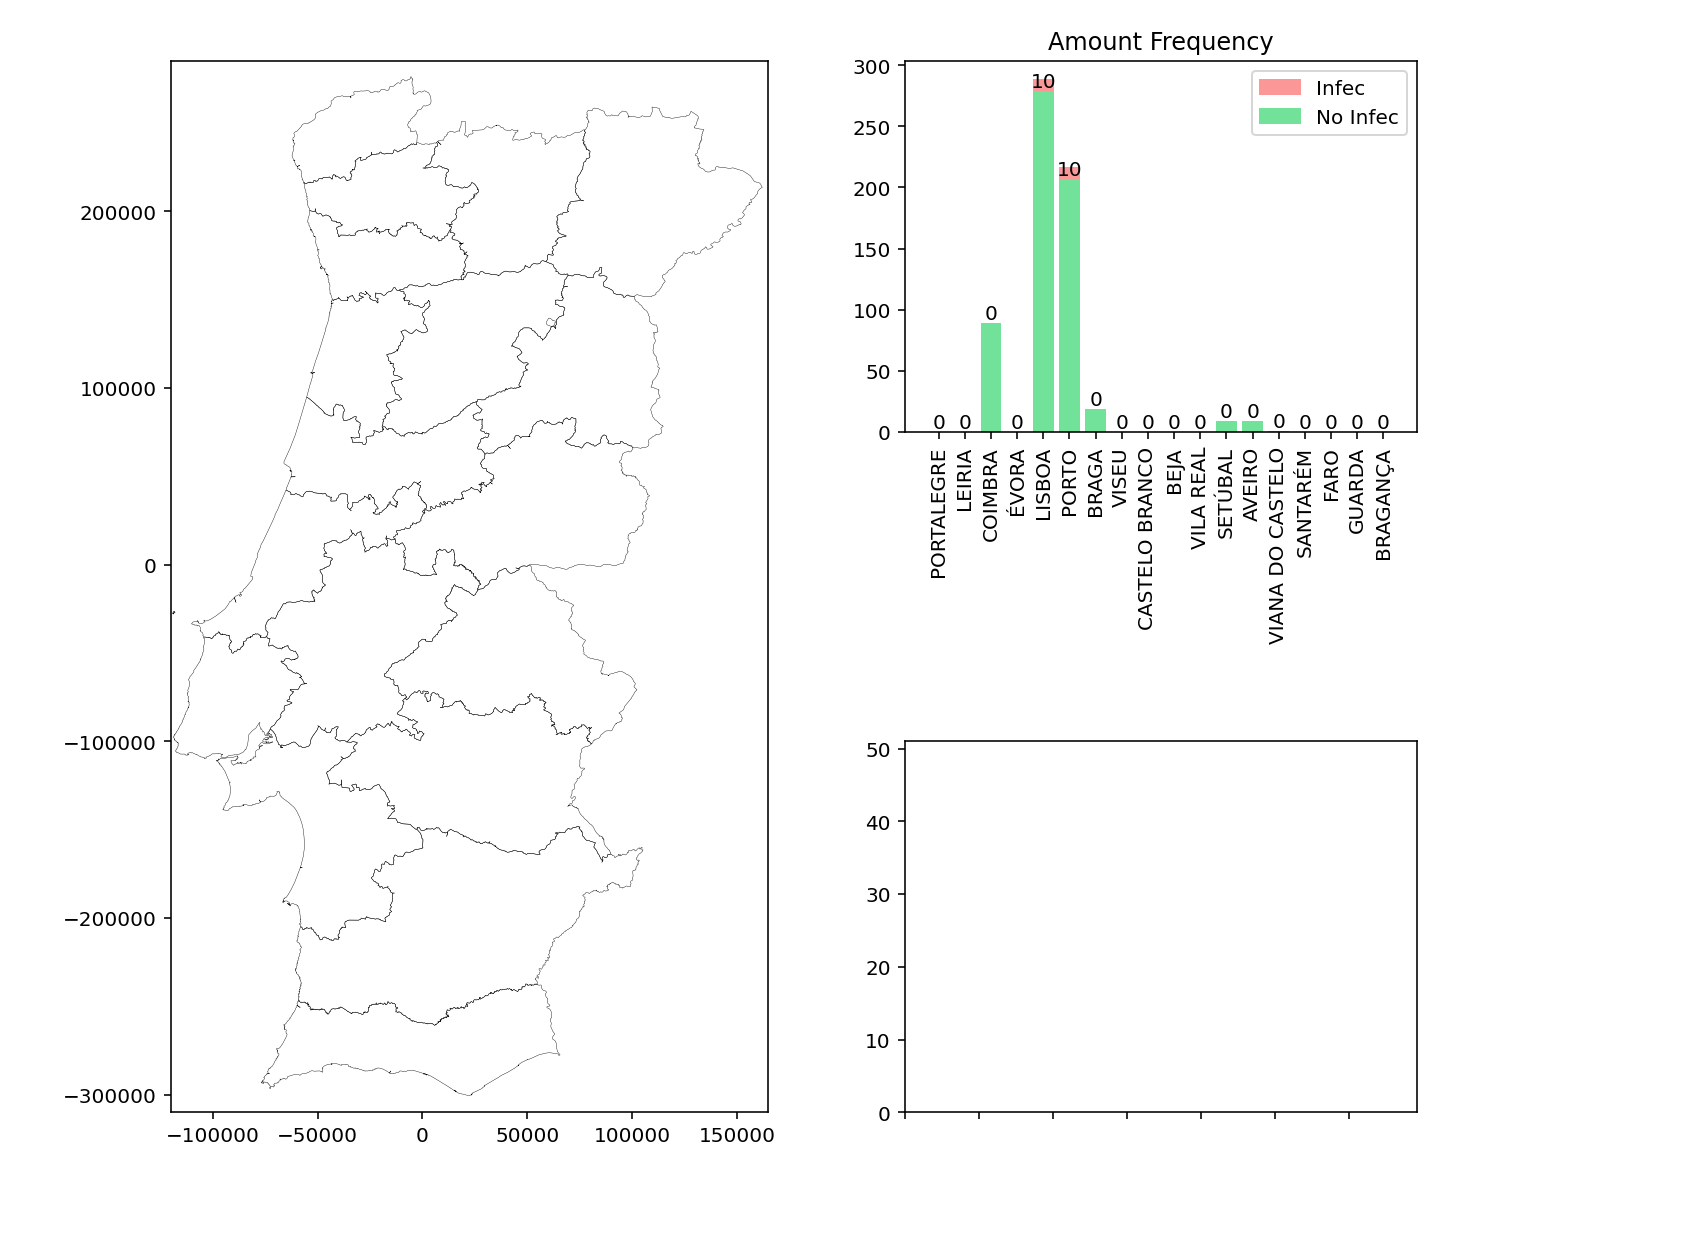

In [974]:
movie = updateMovie()
player = pn.widgets.Player(name='Player', start=0, end=len(movie.frames), value=0, loop_policy='loop', interval=1000)
select_type  = pnw.RadioButtonGroup(name='Type', value='Point', 
                                 options=list(['Point', 'HeatMap', 'QuadTree']))

@pn.depends(player, select_type)
def reactive_outliers(player, select_type_value):
    return show_frame(player, select_type_value)

title = '# Video Player'
occupancy = pn.Column(title, select_type, reactive_outliers, player)
occupancy


# kw = dict(frame_num=(0,len(movie.frames)), figsize_x=(1, 20), figsize_y=(1, 20))
# i = pn.interact(show_frame, **kw)

# # i.pprint()
# # button.on_click(updateMovie)

# p = pn.Row(i[1][0], pn.Column(title, i[0][0], play_video, pn.Row(button_play, button_pause)))
# p

# Tests

## Districts

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Select(name='councils', options=['ABRANTES', 'AGUIAR DA BE...], value='PORTO')
        [1] Player(end=173, interval=1000, loop_policy='loop')
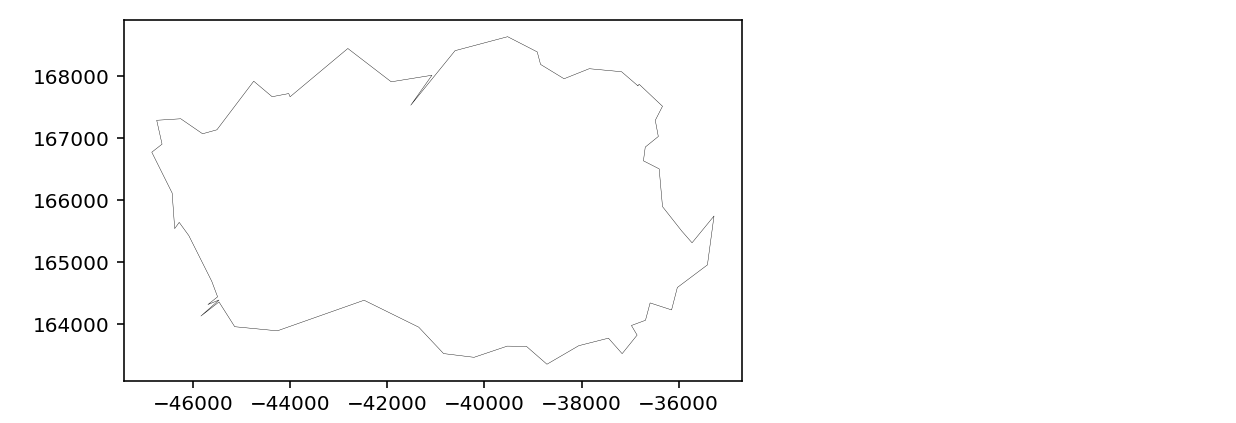

In [722]:
# countrys
# districts
# councils
# parishes

import panel.widgets as pnw
district  = pn.widgets.Select(name='councils', value='PORTO', options=list(movie.councils))
frame_index = pn.widgets.Player(name='Player', start=0, end=len(movie.frames), value=0, loop_policy='loop', interval=1000)
# frame_index = pnw.IntSlider(name='Frame', value=0, start=0, end=len(movie.frames))

@pn.depends(district, frame_index)
def find_outliers(index=0, frame_index=0):
    fig = Figure()
    return movie.councils[index].plot(fig, frame_index)

occupancy = pn.Row(find_outliers, pn.Column(district, frame_index))
# occupancy = pn.Column(find_outliers, index, frame_index)
occupancy

# Test video

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [ ]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [ ]:
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [ ]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [ ]:
HTML(anim.to_html5_video())

# Testes DataBase

In [ ]:
len(districts[16].freguesia)

In [ ]:
for i in range(len(districts)):
    print(str(i)+': '+districts[i].name)

## test postgis

In [ ]:
from random import randint
xs = [randint(-50000, 50000) for i in range(600000)]
ys = [randint(-50000, 50000) for i in range(600000)]

In [ ]:
# def test():
#     conn = psycopg2.connect(database="lucparada", user="lucparada", password='', host="127.0.0.1", port="9876")
#     register(conn)
#     cursor_psql = conn.cursor()
#     result = []
#     sql="SELECT distrito FROM cont_aad_caop2018 WHERE "
# #     for i in progressbar.progressbar(range(len(xs)-1)):
# #         sql+="ST_Contains(proj_boundary, ST_GeometryFromText('POINT(" + str(xs[i]) + " " + str(ys[i]) + ")',3763)) or "
# #     sql+="ST_Contains(proj_boundary, ST_GeometryFromText('POINT(" + str(xs[len(xs)-1]) + " " + str(ys[len(xs)-1]) + ")',3763));"
    
#     cursor_psql.execute(sql)
#     results = cursor_psql.fetchall()
    
# #     for i in progressbar.progressbar(range(100000), prefix='test: ', redirect_stdout=True):
# # #         sql+="SELECT distrito FROM cont_aad_caop2018 WHERE ST_Contains(proj_boundary, ST_GeometryFromText('POINT(-40000 170000)',3763));"
# #         sql = "SELECT distrito FROM cont_aad_caop2018 WHERE ST_Contains(proj_boundary, ST_GeometryFromText('POINT(-40000 170000)',3763));"
# #         cursor_psql.execute(sql)
# #         results = cursor_psql.fetchall()
# #         for row in results:
# #             result.append(row[0])
#     return result


# test()

    
    
    
    

In [ ]:
randint

In [ ]:
from progress.spinner import PixelSpinner
from time import sleep

with PixelSpinner('Processing...') as bar:
    for i in range(100):
        sleep(0.06)
        bar.next()

In [ ]:
# movie = Movie(taxi_matrix = taxi_matrix[0:int(len(taxi_matrix)*(range_video.value/100)):density.value], probability=probability.value, districts=districts)
conn = movie.make_conn()
print(movie.get_taxi_district(conn, (0, 0)).name)
text = ''
for t in movie.taxis:
    point = t.get_first_position()
    text+=str(point)
    print(point)
    if point!=(0, 0):
        print(movie.get_taxi_district(conn, point).name)
        




In [ ]:
movie.districts[5].dimension

In [ ]:
movie.districts['PORTO'].dimension

In [ ]:
harvest = np.array([[ randint(0, 10) for i in range(10)] for i in range(10)])

cmap = plt.cm.get_cmap('RdYlGn').reversed()
fig, ax = plt.subplots()
im = ax.imshow(harvest, cmap=cmap)

# Create colorbar
cbarlabel="Quality Rating"

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

ax.set_title("Harvest of local farmers (in tons/year)")

plt.show()

# Place

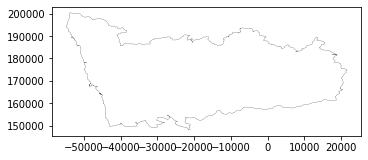

In [698]:
movie.districts['PORTO'].plot(1)

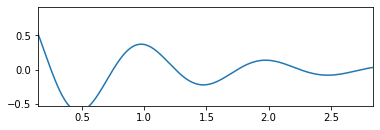

In [757]:
import numpy as np
import matplotlib.pyplot as plt


def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


t1 = np.arange(0.0, 3.0, 0.01)

ax1 = plt.subplot(212)
ax1.margins(-0.05)           # Default margin is 0.05, value 0 means fit
# ax1.set_xlim(0, 5)


ax1.plot(t1, f(t1))

# ax2 = plt.subplot(221)
# ax2.margins(2, 2)           # Values >0.0 zoom out
# ax2.plot(t1, f(t1))
# ax2.set_title('Zoomed out')

# ax3 = plt.subplot(222)
# ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
# ax3.plot(t1, f(t1))
# ax3.set_title('Zoomed in')

plt.show()

# Test Zoom & Navigation

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] RadioButtonGroup(name='variable', options=['date', 'Temperature', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=10)
        [3] FloatSlider(end=100, name='zomm', start=1, value=1)
        [4] IntSlider(end=4000, name='x', start=-1500, value=1500)
        [5] IntSlider(end=100, name='y', value=20)
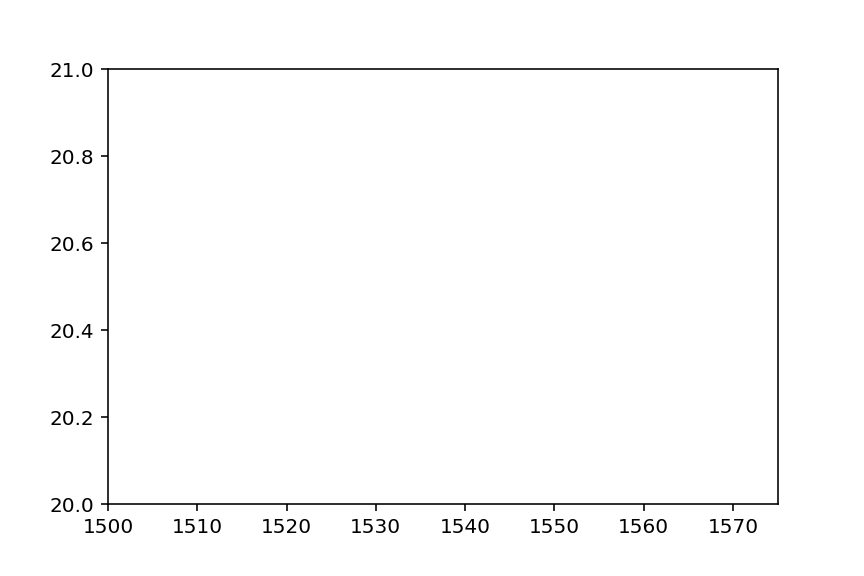

In [961]:
data = pd.read_csv('occupancy.csv')
data['date'] = data.date.astype('datetime64[ns]')
# data = data.set_index('date')
data['i'] = [i for i in range(len(data))]
data.set_index('i')

def mpl_plot(avg, highlight, zoom_val, x_axis_val, y_axis_val):
    fig = Figure()
    FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    

# ZOOM :D
    ax.set(xlim=(x_axis_val, x_axis_val+(75*zoom_val)), ylim=(y_axis_val, y_axis_val+zoom_val))
    ax.transLimits.transform((x_axis_val, y_axis_val))
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Temperature', window=30, sigma=10, zoom_val=0, x_axis_val=1500, y_axis_val=20):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return mpl_plot(avg, avg[outliers], zoom_val, x_axis_val, y_axis_val)


variable  = pnw.RadioButtonGroup(name='variable', value='Temperature', 
                                 options=list(data.columns))
window  = pnw.IntSlider(name='window', value=10, start=1, end=60)

zoom  = pnw.FloatSlider(name='zomm', value=1, start=1, end=100, step=0.1)
x_axis  = pnw.IntSlider(name='x', value=1500, start=-1500, end=4000)
y_axis  = pnw.IntSlider(name='y', value=20, start=0, end=100)

@pn.depends(variable, window, zoom, x_axis, y_axis)
def reactive_outliers(variable, window, zoom_val, x_axis_val, y_axis_val):
    return find_outliers(variable, window, 10, zoom_val, x_axis_val, y_axis_val)

widgets   = pn.Column("<br>\n# Room occupancy", variable, window, zoom, x_axis, y_axis)
occupancy = pn.Row(reactive_outliers, widgets)
occupancy

In [868]:
data['i'] = [i for i in range(len(data))]
data.set_index('i')
data

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,i
date,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...
2660,NaN,NaN,NaN,NaN,NaN,NaN,2660
2661,NaN,NaN,NaN,NaN,NaN,NaN,2661
2662,NaN,NaN,NaN,NaN,NaN,NaN,2662


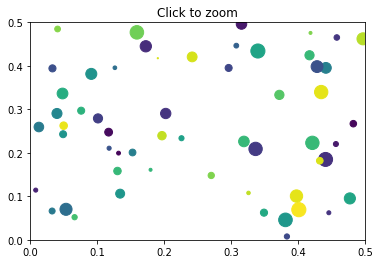

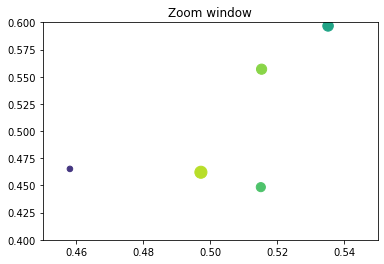

In [795]:
import matplotlib.pyplot as plt
import numpy as np

figsrc, axsrc = plt.subplots()
figzoom, axzoom = plt.subplots()
axsrc.set(xlim=(0, .5), ylim=(0, .5), autoscale_on=False,
          title='Click to zoom')
axzoom.set(xlim=(0.45, 0.55), ylim=(0.4, 0.6), autoscale_on=False,
           title='Zoom window')

x, y, s, c = np.random.rand(4, 200)
s *= 200

axsrc.scatter(x, y, s, c)
axzoom.scatter(x, y, s, c)


def onpress(event):
    if event.button != 1:
        return
    x, y = event.xdata, event.ydata
    axzoom.set_xlim(x - 0.1, x + 0.1)
    axzoom.set_ylim(y - 0.1, y + 0.1)
    figzoom.canvas.draw()

figsrc.canvas.mpl_connect('button_press_event', onpress)
plt.show()